In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-07 22:47:37--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  32.7MB/s    in 3.4s    

2024-12-07 22:47:41 (31.1 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 14.23it/s]


Epoch 1, Train Loss: 2.289, Train Accuracy: 12.80%
Epoch 1, Val Loss: 2.179, Val Accuracy: 26.60%


100%|██████████| 16/16 [00:00<00:00, 22.02it/s]


Epoch 2, Train Loss: 1.987, Train Accuracy: 34.10%
Epoch 2, Val Loss: 1.595, Val Accuracy: 57.40%


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


Epoch 3, Train Loss: 1.204, Train Accuracy: 61.80%
Epoch 3, Val Loss: 0.713, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


Epoch 4, Train Loss: 0.689, Train Accuracy: 76.50%
Epoch 4, Val Loss: 0.432, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:01<00:00, 15.71it/s]


Epoch 5, Train Loss: 0.459, Train Accuracy: 85.80%
Epoch 5, Val Loss: 0.373, Val Accuracy: 88.20%
Treinamento concluído


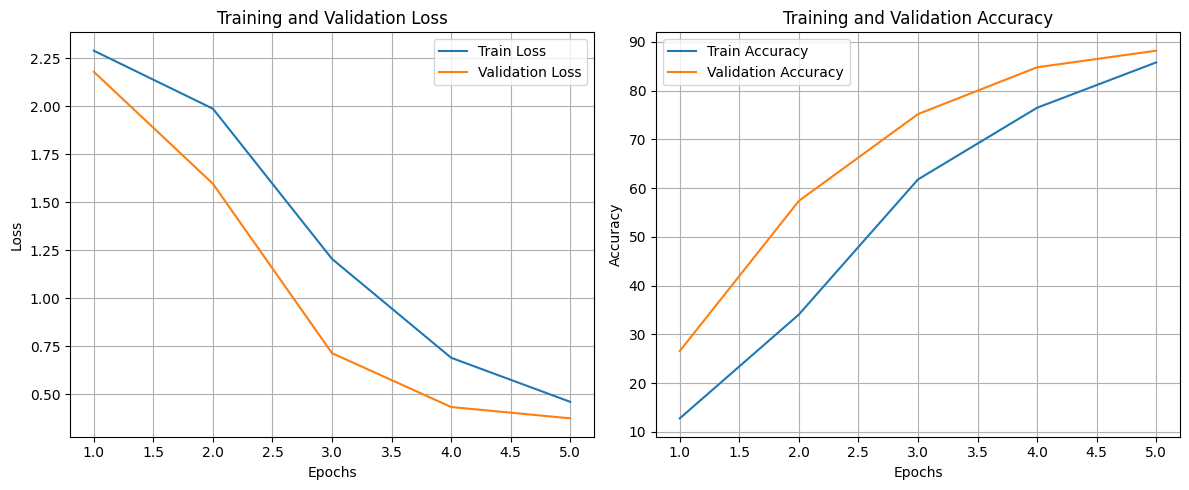

In [11]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 89.40%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [13]:
class CNN_ex1(nn.Module):
    def __init__(self,
                 initialize_weights=True, dropout=0.2,
                 filter_layer1=6, filter_layer2=12):
        super(CNN_ex1, self).__init__()

        self.num_filters_layer1 = filter_layer1
        self.num_filters_layer2 = filter_layer2

        self.conv1 = nn.Conv2d(1, self.num_filters_layer1, 5)
        self.conv2 = nn.Conv2d(self.num_filters_layer1, self.num_filters_layer2, 5)
        self.fc1 = nn.Linear(self.num_filters_layer2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_layer2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [14]:
params_grid = [(6,12),
               (6,16),
               (8,12),
               (8,16)]


# grid serach de numero de filtros
for num_filters_layer1, num_filters_layer2 in params_grid:
  print(f'Número de filtros ({num_filters_layer1}x{num_filters_layer2})')
  model = CNN_ex1(
      initialize_weights=True,
      dropout=0.2,
      filter_layer1=num_filters_layer1,
      filter_layer2=num_filters_layer2
  )

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  history = train_model(
      model=model,
      trainloader=trainloader,
      valloader=valloader,
      criterion=criterion,
      optimizer=optimizer
  )
  test_model(model, testloader)


Número de filtros (6x12)


100%|██████████| 16/16 [00:00<00:00, 22.37it/s]


Epoch 1, Train Loss: 2.261, Train Accuracy: 16.10%
Epoch 1, Val Loss: 2.202, Val Accuracy: 22.00%


100%|██████████| 16/16 [00:00<00:00, 22.06it/s]


Epoch 2, Train Loss: 1.992, Train Accuracy: 35.00%
Epoch 2, Val Loss: 1.655, Val Accuracy: 54.20%


100%|██████████| 16/16 [00:00<00:00, 21.75it/s]


Epoch 3, Train Loss: 1.280, Train Accuracy: 58.20%
Epoch 3, Val Loss: 0.783, Val Accuracy: 75.40%


100%|██████████| 16/16 [00:00<00:00, 21.91it/s]


Epoch 4, Train Loss: 0.707, Train Accuracy: 74.40%
Epoch 4, Val Loss: 0.500, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


Epoch 5, Train Loss: 0.466, Train Accuracy: 84.80%
Epoch 5, Val Loss: 0.374, Val Accuracy: 89.40%
Treinamento concluído
Acurácia da rede na base de teste: 92.80%
Número de filtros (6x16)


100%|██████████| 16/16 [00:00<00:00, 21.74it/s]


Epoch 1, Train Loss: 2.273, Train Accuracy: 17.50%
Epoch 1, Val Loss: 2.094, Val Accuracy: 33.60%


100%|██████████| 16/16 [00:00<00:00, 21.46it/s]


Epoch 2, Train Loss: 1.818, Train Accuracy: 40.30%
Epoch 2, Val Loss: 1.290, Val Accuracy: 60.60%


100%|██████████| 16/16 [00:00<00:00, 21.27it/s]


Epoch 3, Train Loss: 1.069, Train Accuracy: 64.00%
Epoch 3, Val Loss: 0.626, Val Accuracy: 79.40%


100%|██████████| 16/16 [00:01<00:00, 15.66it/s]


Epoch 4, Train Loss: 0.667, Train Accuracy: 78.30%
Epoch 4, Val Loss: 0.421, Val Accuracy: 88.00%


100%|██████████| 16/16 [00:01<00:00, 14.63it/s]


Epoch 5, Train Loss: 0.538, Train Accuracy: 82.10%
Epoch 5, Val Loss: 0.365, Val Accuracy: 88.60%
Treinamento concluído
Acurácia da rede na base de teste: 90.00%
Número de filtros (8x12)


100%|██████████| 16/16 [00:00<00:00, 20.75it/s]


Epoch 1, Train Loss: 2.280, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.230, Val Accuracy: 23.00%


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Epoch 2, Train Loss: 2.144, Train Accuracy: 27.50%
Epoch 2, Val Loss: 1.963, Val Accuracy: 41.80%


100%|██████████| 16/16 [00:00<00:00, 21.52it/s]


Epoch 3, Train Loss: 1.657, Train Accuracy: 48.30%
Epoch 3, Val Loss: 1.159, Val Accuracy: 65.40%


100%|██████████| 16/16 [00:00<00:00, 21.59it/s]


Epoch 4, Train Loss: 0.970, Train Accuracy: 66.60%
Epoch 4, Val Loss: 0.618, Val Accuracy: 83.80%


100%|██████████| 16/16 [00:00<00:00, 21.38it/s]


Epoch 5, Train Loss: 0.601, Train Accuracy: 79.40%
Epoch 5, Val Loss: 0.420, Val Accuracy: 86.60%
Treinamento concluído
Acurácia da rede na base de teste: 88.00%
Número de filtros (8x16)


100%|██████████| 16/16 [00:00<00:00, 20.93it/s]


Epoch 1, Train Loss: 2.252, Train Accuracy: 18.60%
Epoch 1, Val Loss: 2.117, Val Accuracy: 29.20%


100%|██████████| 16/16 [00:00<00:00, 21.33it/s]


Epoch 2, Train Loss: 1.883, Train Accuracy: 39.00%
Epoch 2, Val Loss: 1.323, Val Accuracy: 66.20%


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]


Epoch 3, Train Loss: 1.030, Train Accuracy: 66.30%
Epoch 3, Val Loss: 0.634, Val Accuracy: 79.20%


100%|██████████| 16/16 [00:00<00:00, 18.14it/s]


Epoch 4, Train Loss: 0.622, Train Accuracy: 78.90%
Epoch 4, Val Loss: 0.469, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:01<00:00, 15.75it/s]


Epoch 5, Train Loss: 0.444, Train Accuracy: 85.10%
Epoch 5, Val Loss: 0.365, Val Accuracy: 89.40%
Treinamento concluído
Acurácia da rede na base de teste: 91.00%


### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [16]:
class CNN_ex2(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2,
                 num_neurons_fc1=64):
        super(CNN_ex2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, num_neurons_fc1)
        self.fc2 = nn.Linear(num_neurons_fc1, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [18]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    model = CNN_ex2(
        initialize_weights=True,
        dropout=0.2,
        num_neurons_fc1=num_neurons
    )
    model.fc1 = nn.Linear(12 * 4 * 4, num_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    print(f'Número de neurônios na camada fully connected: {num_neurons}')
    test_model(model, testloader)
    print()

100%|██████████| 16/16 [00:00<00:00, 21.30it/s]


Epoch 1, Train Loss: 2.223, Train Accuracy: 23.00%
Epoch 1, Val Loss: 2.063, Val Accuracy: 42.20%


100%|██████████| 16/16 [00:00<00:00, 21.59it/s]


Epoch 2, Train Loss: 1.661, Train Accuracy: 49.50%
Epoch 2, Val Loss: 0.972, Val Accuracy: 76.80%


100%|██████████| 16/16 [00:00<00:00, 21.38it/s]


Epoch 3, Train Loss: 0.897, Train Accuracy: 70.40%
Epoch 3, Val Loss: 0.594, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 21.39it/s]


Epoch 4, Train Loss: 0.624, Train Accuracy: 80.40%
Epoch 4, Val Loss: 0.510, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 21.39it/s]


Epoch 5, Train Loss: 0.470, Train Accuracy: 85.10%
Epoch 5, Val Loss: 0.425, Val Accuracy: 87.40%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 89.80%



100%|██████████| 16/16 [00:00<00:00, 21.25it/s]


Epoch 1, Train Loss: 2.292, Train Accuracy: 15.10%
Epoch 1, Val Loss: 2.232, Val Accuracy: 28.00%


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


Epoch 2, Train Loss: 2.121, Train Accuracy: 34.80%
Epoch 2, Val Loss: 1.914, Val Accuracy: 51.40%


100%|██████████| 16/16 [00:01<00:00, 12.84it/s]


Epoch 3, Train Loss: 1.546, Train Accuracy: 52.00%
Epoch 3, Val Loss: 0.955, Val Accuracy: 70.60%


100%|██████████| 16/16 [00:01<00:00, 12.43it/s]


Epoch 4, Train Loss: 0.887, Train Accuracy: 70.90%
Epoch 4, Val Loss: 0.578, Val Accuracy: 80.60%


100%|██████████| 16/16 [00:01<00:00, 14.16it/s]


Epoch 5, Train Loss: 0.556, Train Accuracy: 82.00%
Epoch 5, Val Loss: 0.464, Val Accuracy: 85.00%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 87.20%



100%|██████████| 16/16 [00:00<00:00, 20.82it/s]


Epoch 1, Train Loss: 2.288, Train Accuracy: 12.70%
Epoch 1, Val Loss: 2.251, Val Accuracy: 14.40%


100%|██████████| 16/16 [00:00<00:00, 21.40it/s]


Epoch 2, Train Loss: 2.149, Train Accuracy: 28.30%
Epoch 2, Val Loss: 2.018, Val Accuracy: 31.00%


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Epoch 3, Train Loss: 1.801, Train Accuracy: 38.60%
Epoch 3, Val Loss: 1.523, Val Accuracy: 55.20%


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Epoch 4, Train Loss: 1.358, Train Accuracy: 53.10%
Epoch 4, Val Loss: 0.886, Val Accuracy: 73.20%


100%|██████████| 16/16 [00:00<00:00, 21.47it/s]


Epoch 5, Train Loss: 0.923, Train Accuracy: 69.10%
Epoch 5, Val Loss: 0.570, Val Accuracy: 85.20%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 86.60%



100%|██████████| 16/16 [00:00<00:00, 21.71it/s]


Epoch 1, Train Loss: 2.287, Train Accuracy: 15.10%
Epoch 1, Val Loss: 2.217, Val Accuracy: 24.40%


100%|██████████| 16/16 [00:00<00:00, 21.57it/s]


Epoch 2, Train Loss: 2.068, Train Accuracy: 32.30%
Epoch 2, Val Loss: 1.833, Val Accuracy: 39.80%


100%|██████████| 16/16 [00:00<00:00, 18.17it/s]


Epoch 3, Train Loss: 1.604, Train Accuracy: 45.00%
Epoch 3, Val Loss: 1.244, Val Accuracy: 58.60%


100%|██████████| 16/16 [00:01<00:00, 15.70it/s]


Epoch 4, Train Loss: 1.080, Train Accuracy: 62.70%
Epoch 4, Val Loss: 0.796, Val Accuracy: 72.40%


100%|██████████| 16/16 [00:01<00:00, 14.23it/s]


Epoch 5, Train Loss: 0.804, Train Accuracy: 72.60%
Epoch 5, Val Loss: 0.536, Val Accuracy: 84.40%
Treinamento concluído
Número de neurônios na camada fully connected: 31
Acurácia da rede na base de teste: 87.00%



100%|██████████| 16/16 [00:00<00:00, 21.20it/s]


Epoch 1, Train Loss: 2.266, Train Accuracy: 18.70%
Epoch 1, Val Loss: 2.213, Val Accuracy: 26.40%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 2, Train Loss: 2.058, Train Accuracy: 40.20%
Epoch 2, Val Loss: 1.771, Val Accuracy: 50.40%


100%|██████████| 16/16 [00:00<00:00, 20.92it/s]


Epoch 3, Train Loss: 1.358, Train Accuracy: 57.00%
Epoch 3, Val Loss: 0.915, Val Accuracy: 72.20%


100%|██████████| 16/16 [00:01<00:00, 15.32it/s]


Epoch 4, Train Loss: 0.842, Train Accuracy: 70.70%
Epoch 4, Val Loss: 0.597, Val Accuracy: 81.40%


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


Epoch 5, Train Loss: 0.607, Train Accuracy: 78.30%
Epoch 5, Val Loss: 0.471, Val Accuracy: 85.00%
Treinamento concluído
Número de neurônios na camada fully connected: 56
Acurácia da rede na base de teste: 85.80%



O melhor modelo nas iterações aleatórias executadas seria o modelo com melhor acurácia na base de teste. No caso em questão, a iteração 1 com **90 neurônios** na camada fc1, atingindo 89% de acc.